# Hands-on tutorial for DeiT

In this notebook, we show how to use the pre-trained models that we provide with torchhub to perform predictions

## Preliminaries

This section contains the necessary imports, installs and downloads necessary for the remaining of this notebook.

In [1]:
# DeiT is built on top of timm version 0.3.2, so need to install it first
!pip install timm==0.3.2

# Download ImageNet category names for nicer display
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-04-24 05:45:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-04-24 05:45:04 (25.4 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
import timm
import torchvision
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from timm.models import vision_transformer
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [2]:
# Read the ImageNet categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_categories = [s.strip() for s in f.readlines()]

In [3]:
# create the data transform that DeiT expects
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

## Using a pre-trained model from TorchHub

In this section, we show how to load a pre-trained models from torchhub and perform inference with it. In here we will use DeiT-base, but you can use any other model that we provide.

In [76]:
timm.__file__

'/usr/local/lib/python3.7/dist-packages/timm/__init__.py'

In [7]:
model = vision_transformer.vit_base_patch16_224(pretrained=True)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [6]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Let's now retrieve an image from a url and return it as a PIL Image

In [46]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
#url = 'https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/dogs_1280p_0.jpg'
url = 'http://thecatandthedog.com/wp-content/uploads/2020/11/105992231-1561667465295gettyimages-521697453.jpeg'
im = Image.open(requests.get(url, stream=True).raw)

Let's see what the image looks like

In [47]:
im = T.Compose([T.Resize(256, interpolation=3),
                T.CenterCrop(224)])(im)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Next, we apply the preprocessing that DeiT expects during inference and run it through the model, computing the 5 classes with highest confidence.

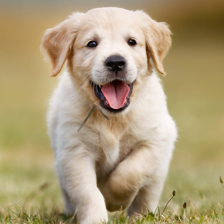

In [48]:
im

In [74]:
def get_attention(att_mat, im):
  att_mat = torch.stack(att_mat).squeeze(1)

  # Average the attention weights across all heads.
  att_mat = torch.mean(att_mat, dim=1)

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
      
  # Attention from the output token to the input space.
  v = joint_attentions[5]
  print(v.size())
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[91, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
  result = mask.reshape(224, 224) #astype("uint8")

  return result

In [69]:
def get_attention(att_mat, im):
  att_mat = torch.stack(att_mat).squeeze(1)

  # Average the attention weights across all heads.
  att_mat = torch.mean(att_mat, dim=1)

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
      
  # Attention from the output token to the input space.
  v = aug_att_mat[1,86,1:]

  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v.reshape(grid_size, grid_size).detach().numpy()
  print(mask.max())
  mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
  result = (mask*im).astype("uint8")

  return result

In [12]:
def denormalize(im):
  mean = torch.tensor(IMAGENET_DEFAULT_MEAN)
  std = torch.tensor(IMAGENET_DEFAULT_STD)
  return im*std[:, None, None] + mean[: , None, None]

In [64]:
# transform the original image and add a batch dimension
def do_things(model ,im, num_attacks=5):
  img = transform(im).unsqueeze(0)
  label = torch.tensor([207])

  images, weights, texts = [], [], [] 

  for i in range(num_attacks):
    model.zero_grad()
    img.requires_grad = True

    # compute the predictions
    out, weight = model(img)
    attn_map = get_attention(weight, im)

    # and convert them into probabilities
    scores = torch.nn.functional.softmax(out, dim=-1)
    loss = torch.nn.functional.nll_loss(scores, label)
    loss.backward()

    imma = T.ToPILImage()(denormalize(img.squeeze(0)))
    img = img + img.grad.data.sign() * 8./255
    img = torch.clamp(img, 0, 1).detach()
    display(imma)
    plt.figure(figsize=(12, 12))
    plt.imshow(attn_map)
    plt.show()


    # finally get the index of the prediction with highest score
    topk_scores, topk_label = torch.topk(scores, k=5, dim=-1)
    print(topk_label)
    
    for i in range(5):
      pred_name = imagenet_categories[topk_label[0, i]]
      print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores[0, i].item():.3f}")
    
  return images, weights, texts 

torch.Size([197, 197])


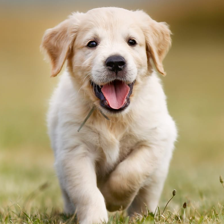

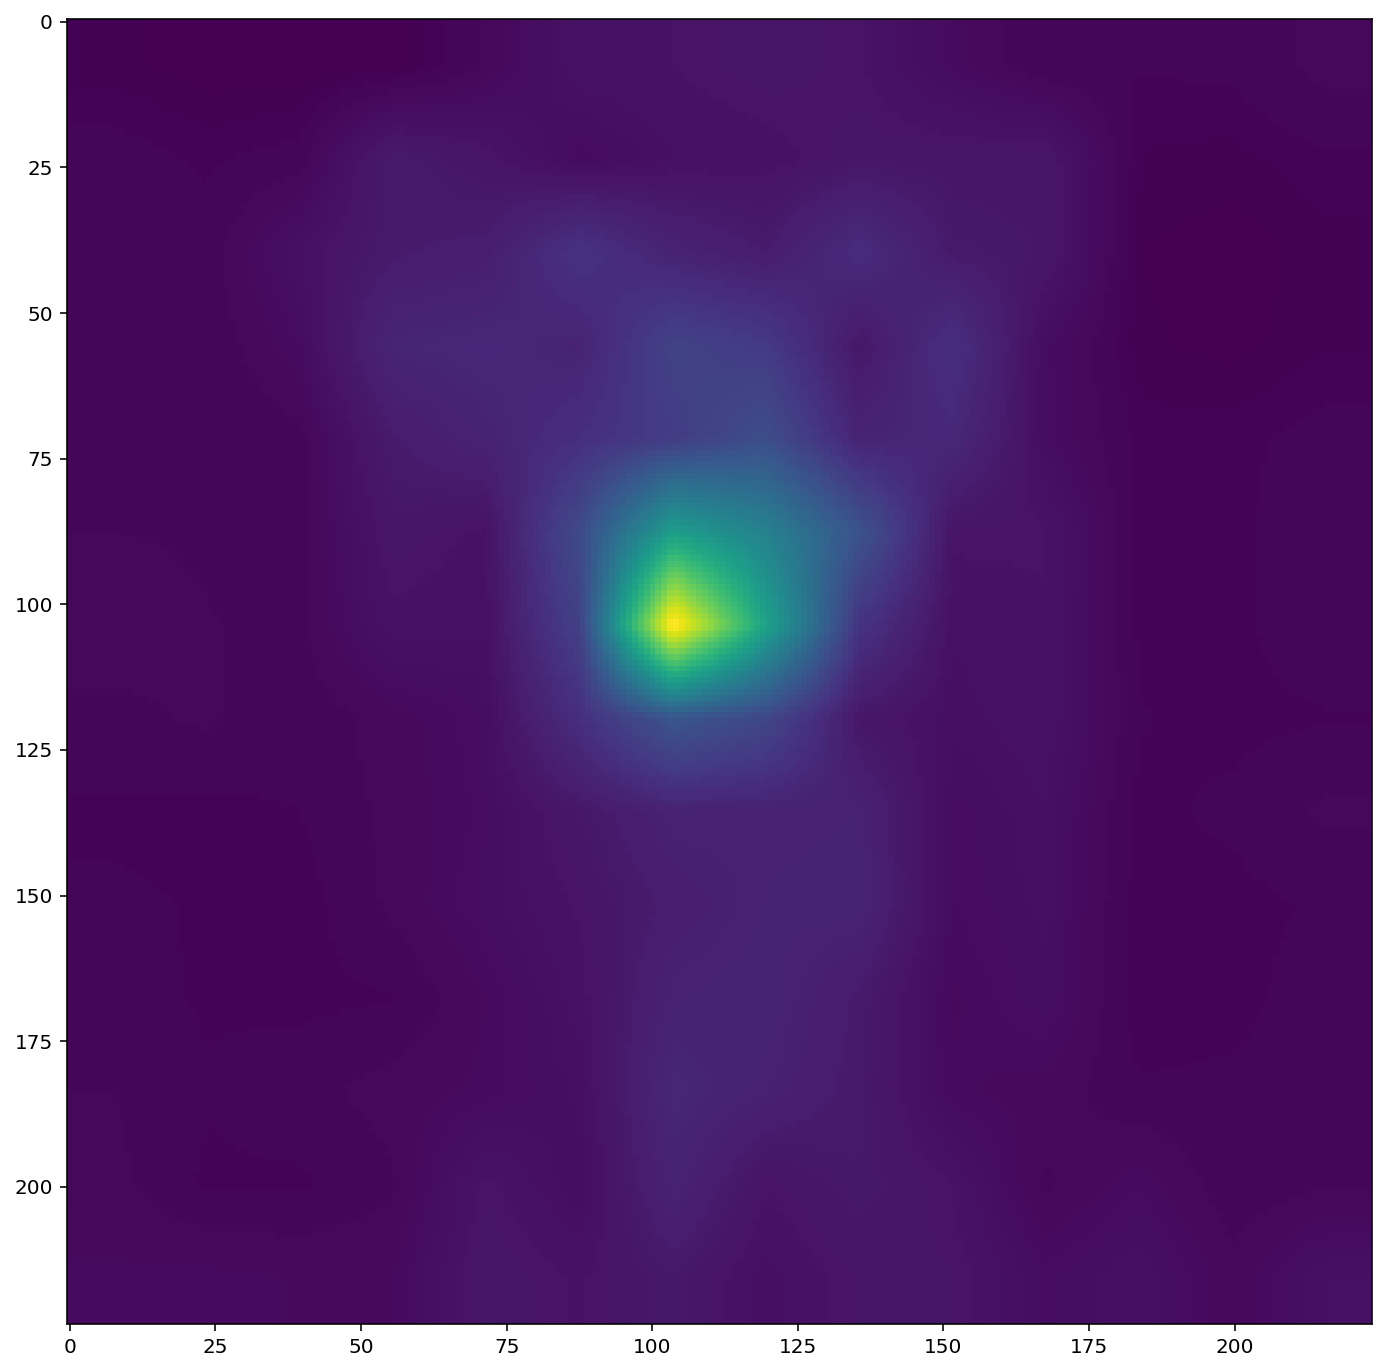

tensor([[207, 208, 216, 215, 852]])
Prediction index 0: golden retriever         , score: 0.983
Prediction index 1: Labrador retriever       , score: 0.007
Prediction index 2: clumber                  , score: 0.002
Prediction index 3: Brittany spaniel         , score: 0.001
Prediction index 4: tennis ball              , score: 0.001
torch.Size([197, 197])


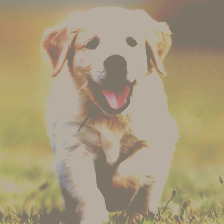

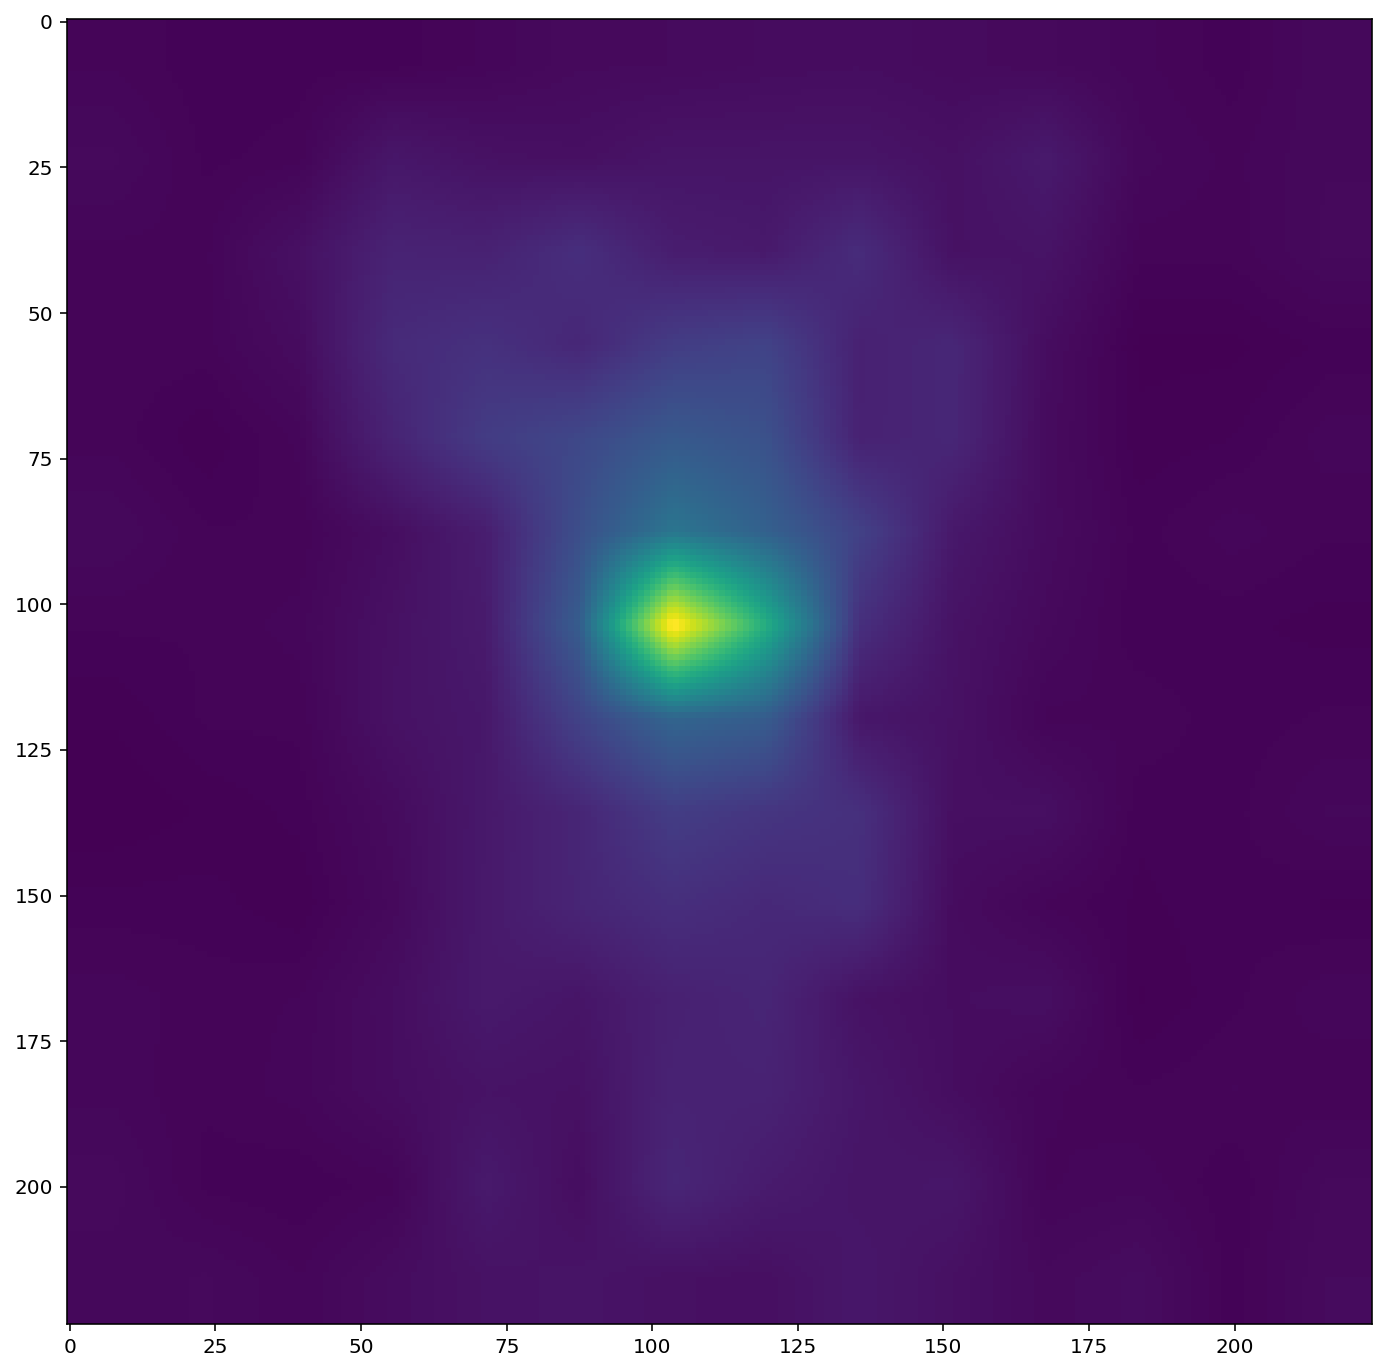

tensor([[208, 207, 215, 216, 219]])
Prediction index 0: Labrador retriever       , score: 0.552
Prediction index 1: golden retriever         , score: 0.380
Prediction index 2: Brittany spaniel         , score: 0.010
Prediction index 3: clumber                  , score: 0.009
Prediction index 4: cocker spaniel           , score: 0.005
torch.Size([197, 197])


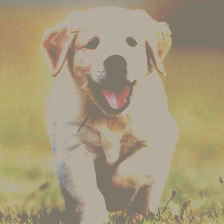

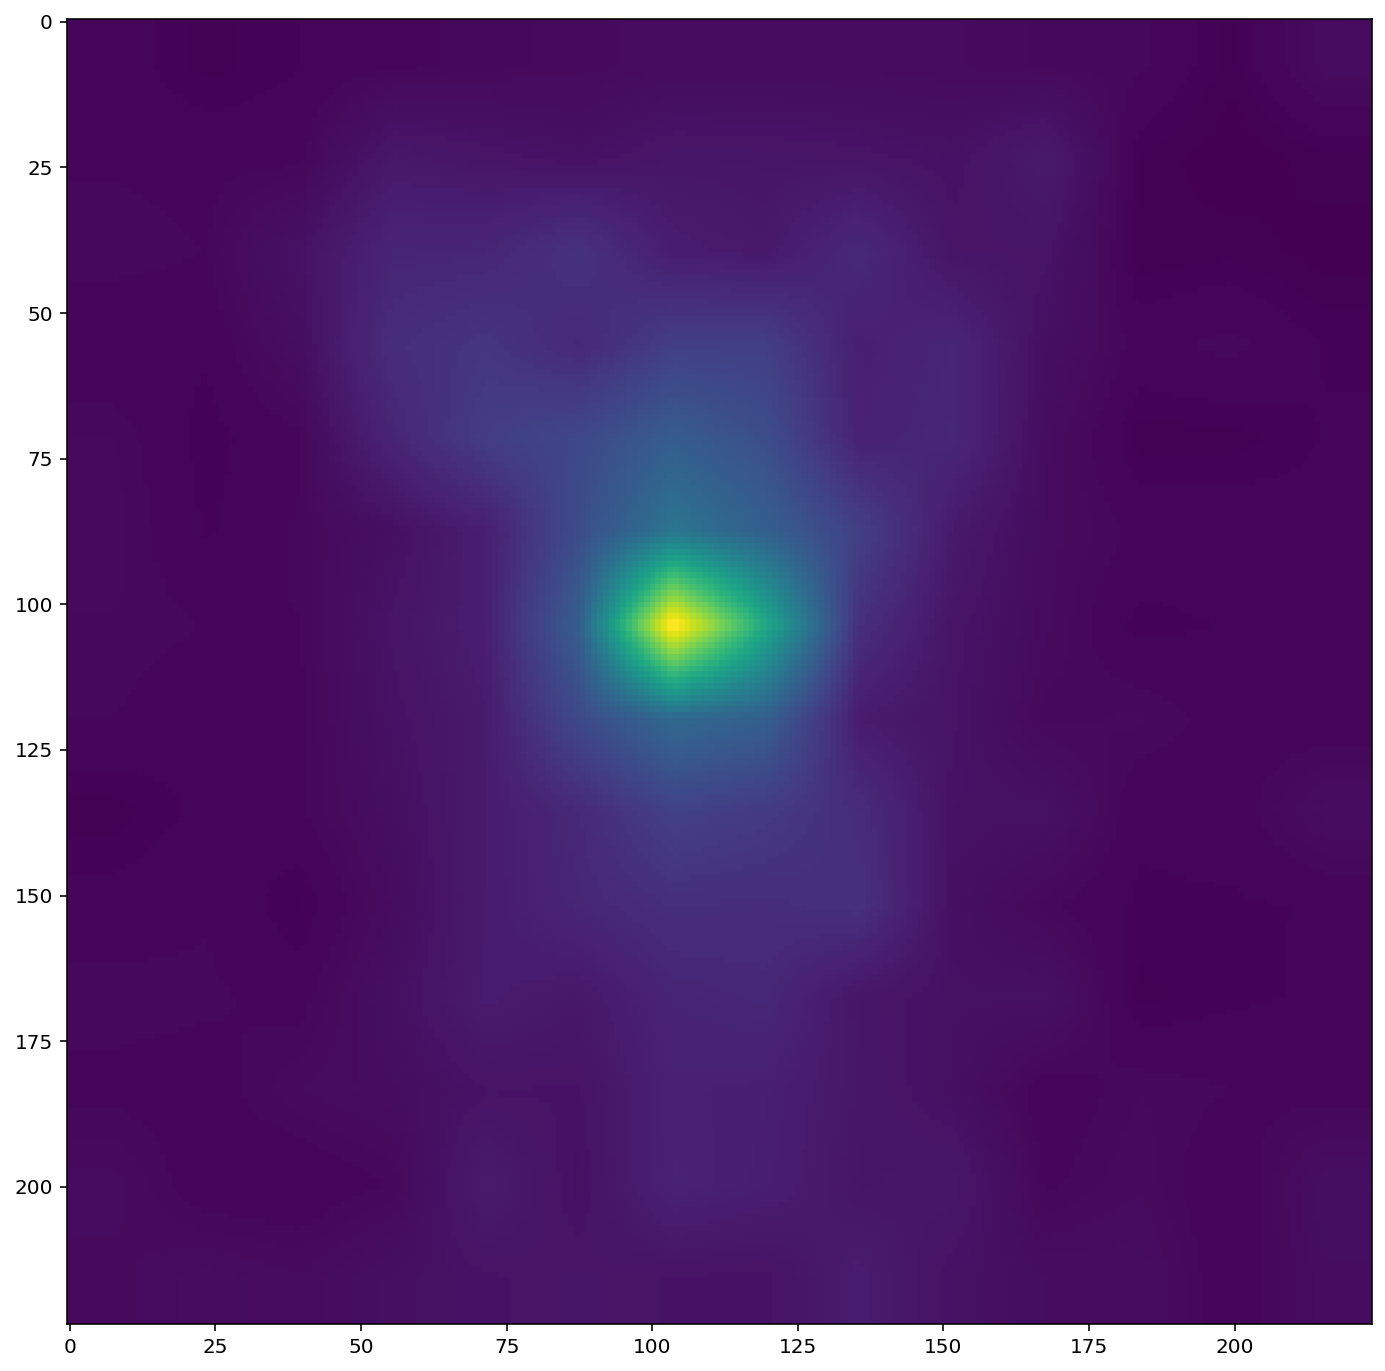

tensor([[254, 208, 243, 676, 852]])
Prediction index 0: pug                      , score: 0.652
Prediction index 1: Labrador retriever       , score: 0.212
Prediction index 2: bull mastiff             , score: 0.057
Prediction index 3: muzzle                   , score: 0.011
Prediction index 4: tennis ball              , score: 0.005
torch.Size([197, 197])


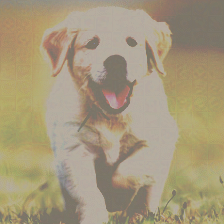

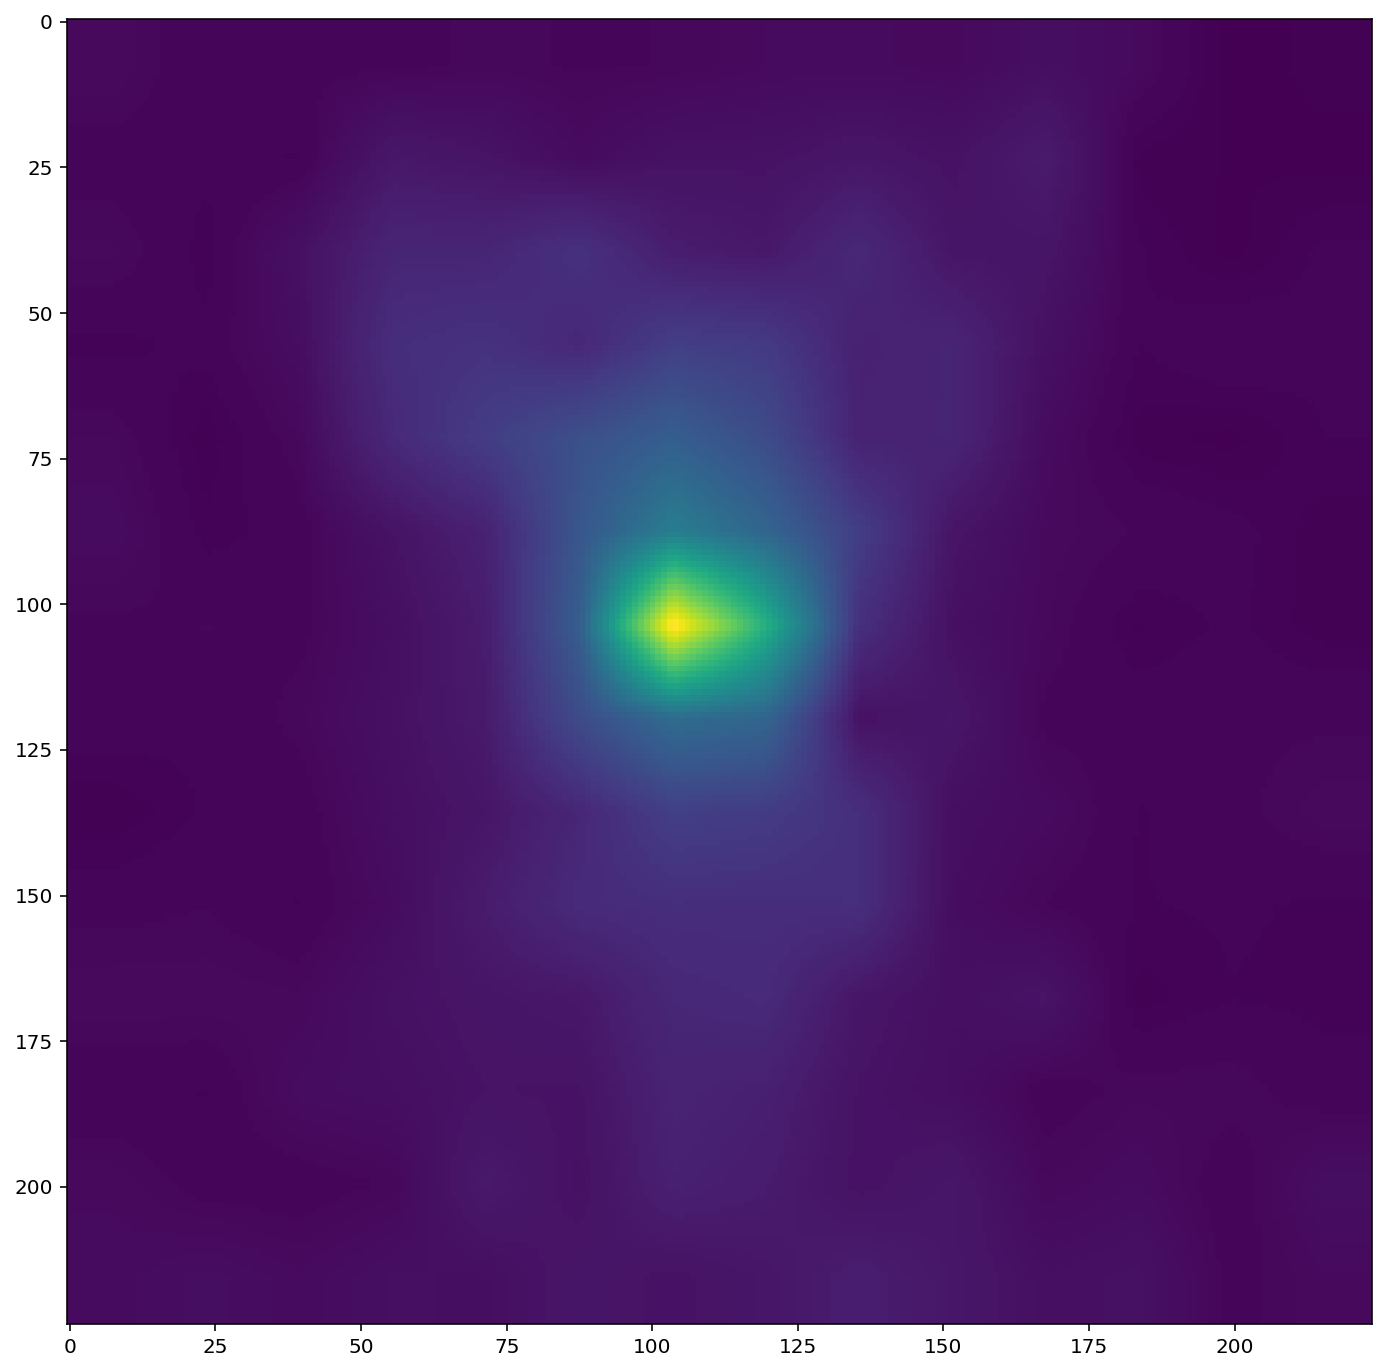

tensor([[254, 245, 243, 195, 151]])
Prediction index 0: pug                      , score: 0.995
Prediction index 1: French bulldog           , score: 0.001
Prediction index 2: bull mastiff             , score: 0.001
Prediction index 3: Boston bull              , score: 0.000
Prediction index 4: Chihuahua                , score: 0.000
torch.Size([197, 197])


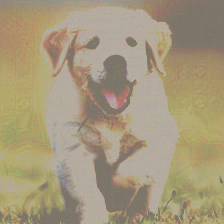

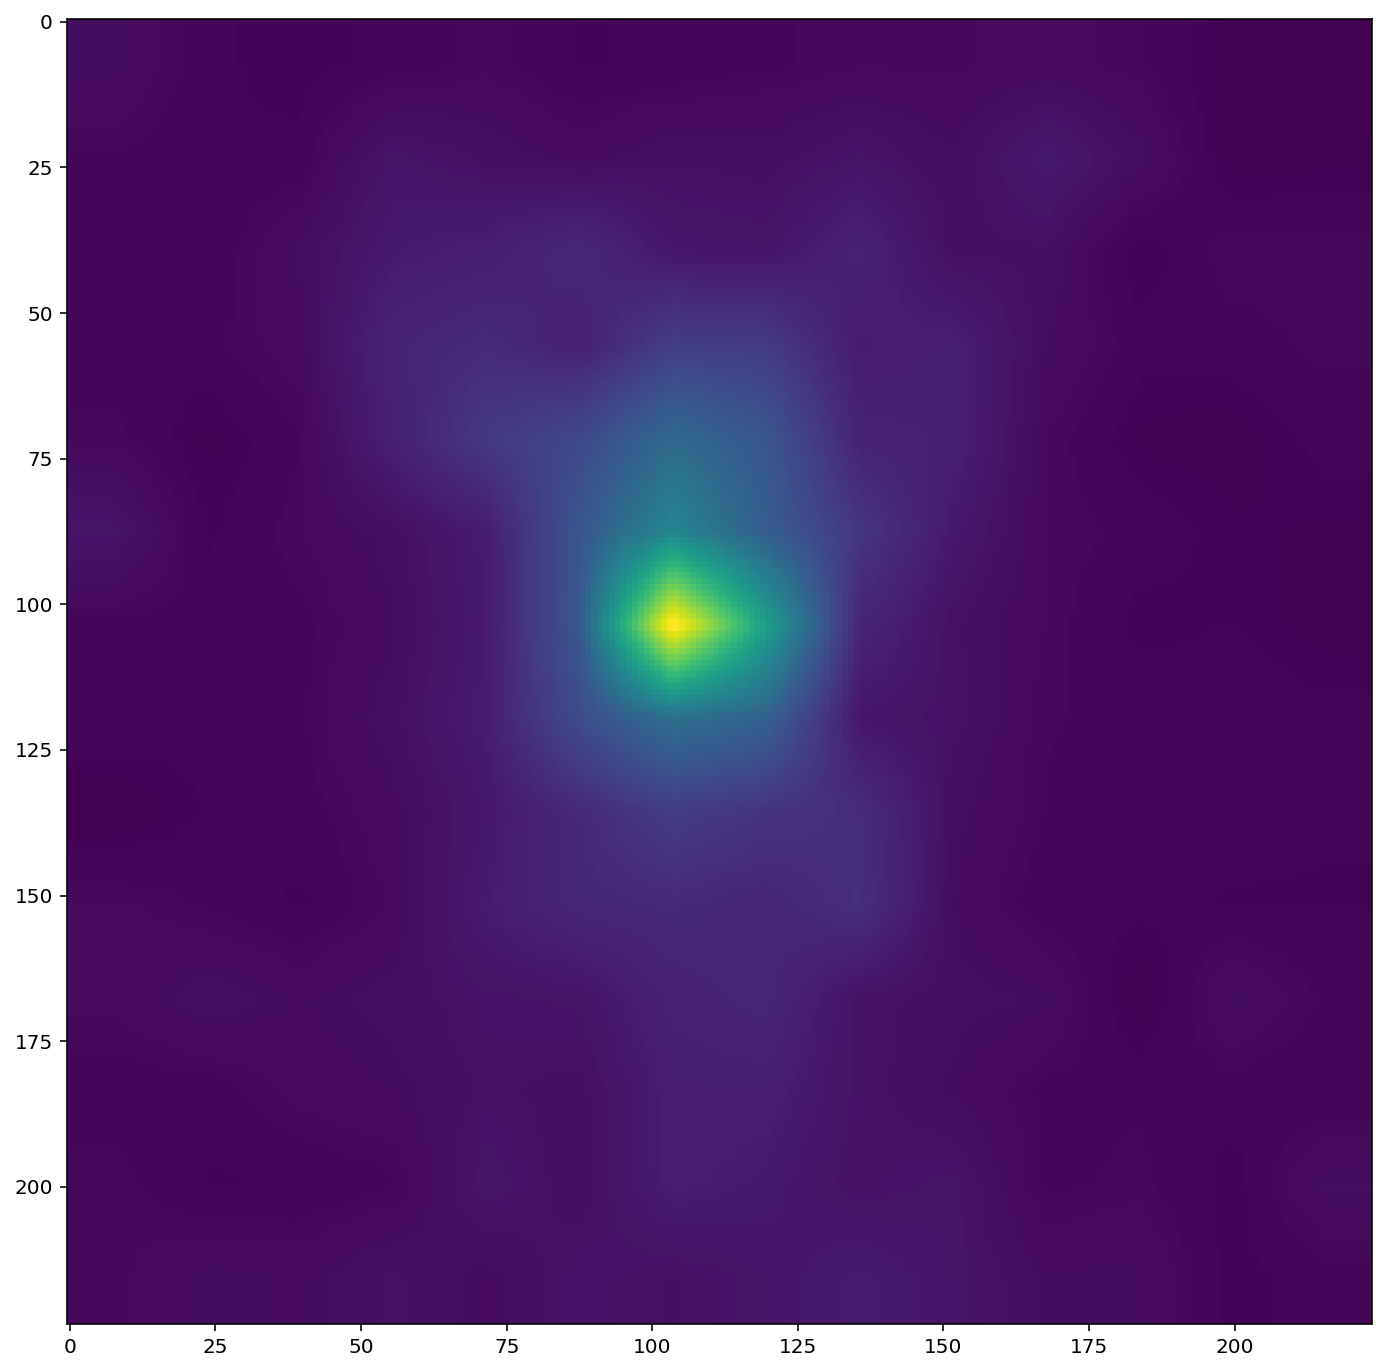

tensor([[619, 846, 883, 448, 708]])
Prediction index 0: lampshade                , score: 0.484
Prediction index 1: table lamp               , score: 0.137
Prediction index 2: vase                     , score: 0.060
Prediction index 3: birdhouse                , score: 0.042
Prediction index 4: pedestal                 , score: 0.017
torch.Size([197, 197])


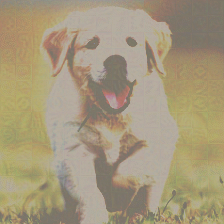

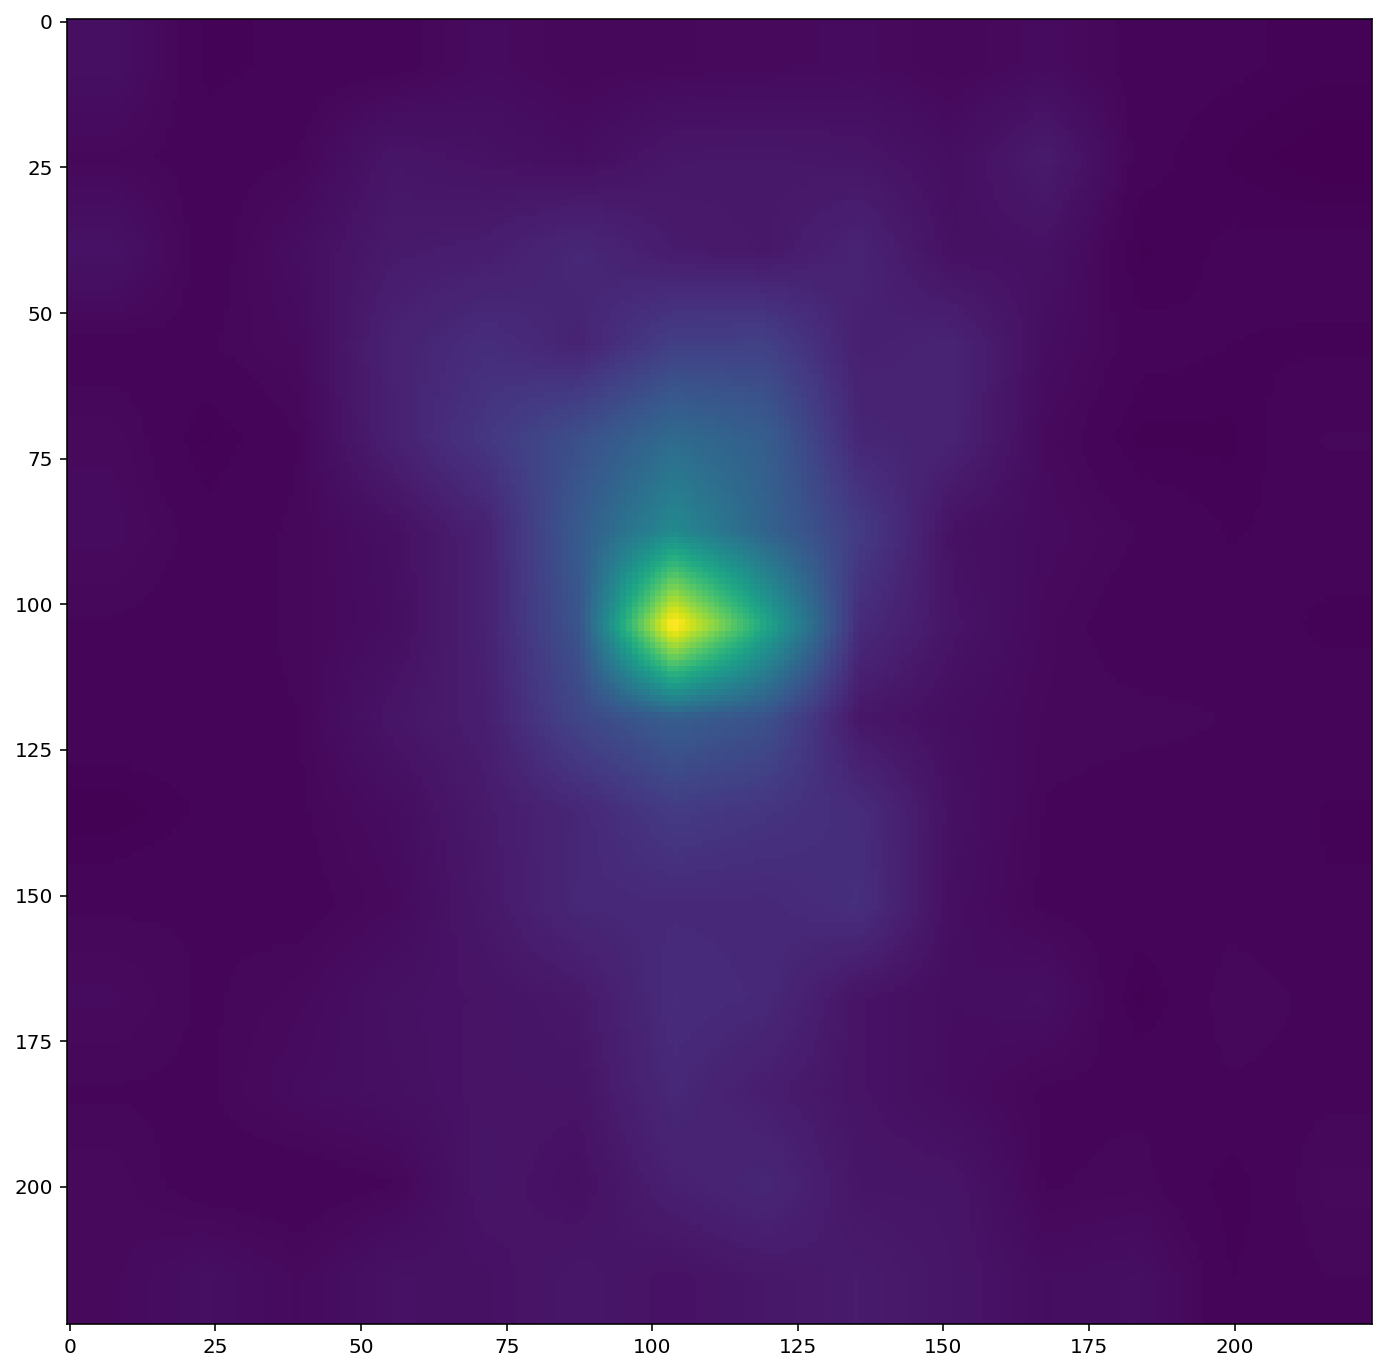

tensor([[619, 846, 818, 883, 545]])
Prediction index 0: lampshade                , score: 0.779
Prediction index 1: table lamp               , score: 0.219
Prediction index 2: spotlight                , score: 0.001
Prediction index 3: vase                     , score: 0.000
Prediction index 4: electric fan             , score: 0.000
torch.Size([197, 197])


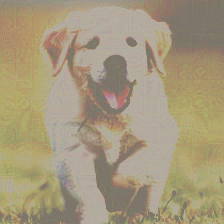

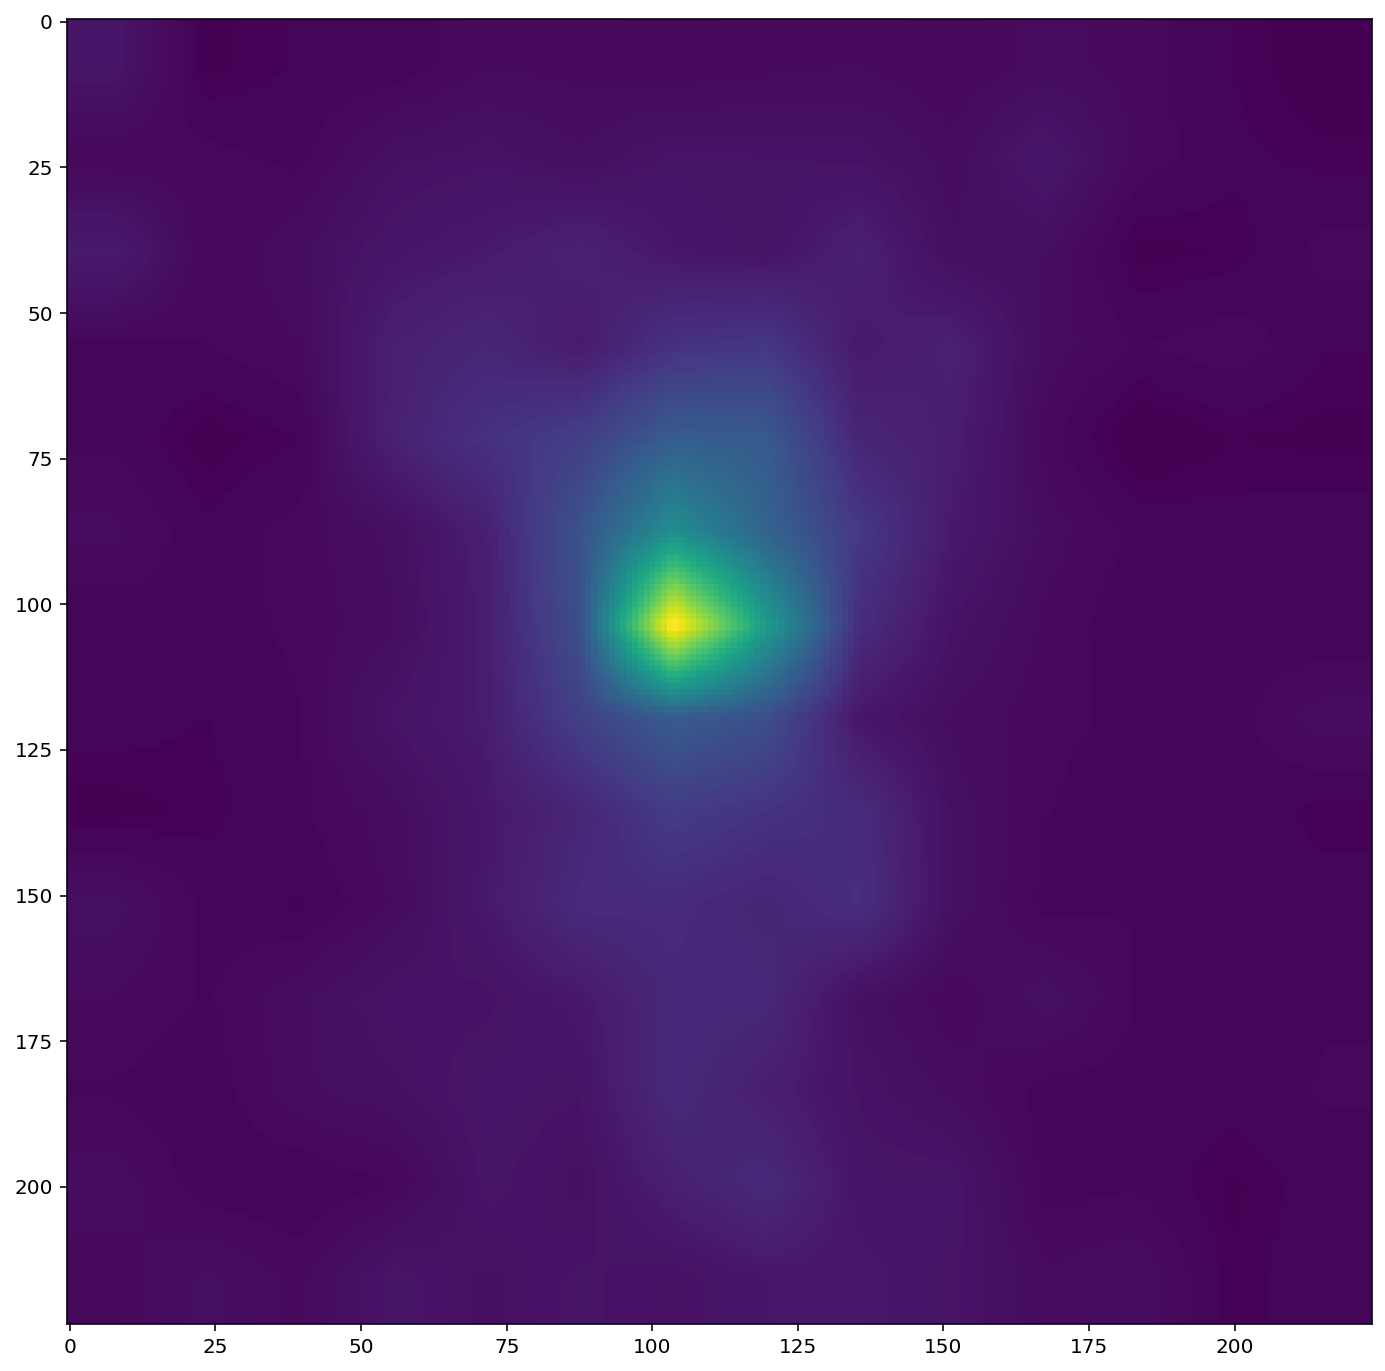

tensor([[619, 846, 855, 883, 588]])
Prediction index 0: lampshade                , score: 0.778
Prediction index 1: table lamp               , score: 0.111
Prediction index 2: thimble                  , score: 0.013
Prediction index 3: vase                     , score: 0.012
Prediction index 4: hamper                   , score: 0.005
torch.Size([197, 197])


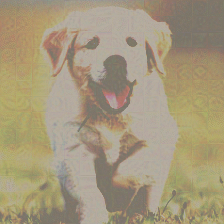

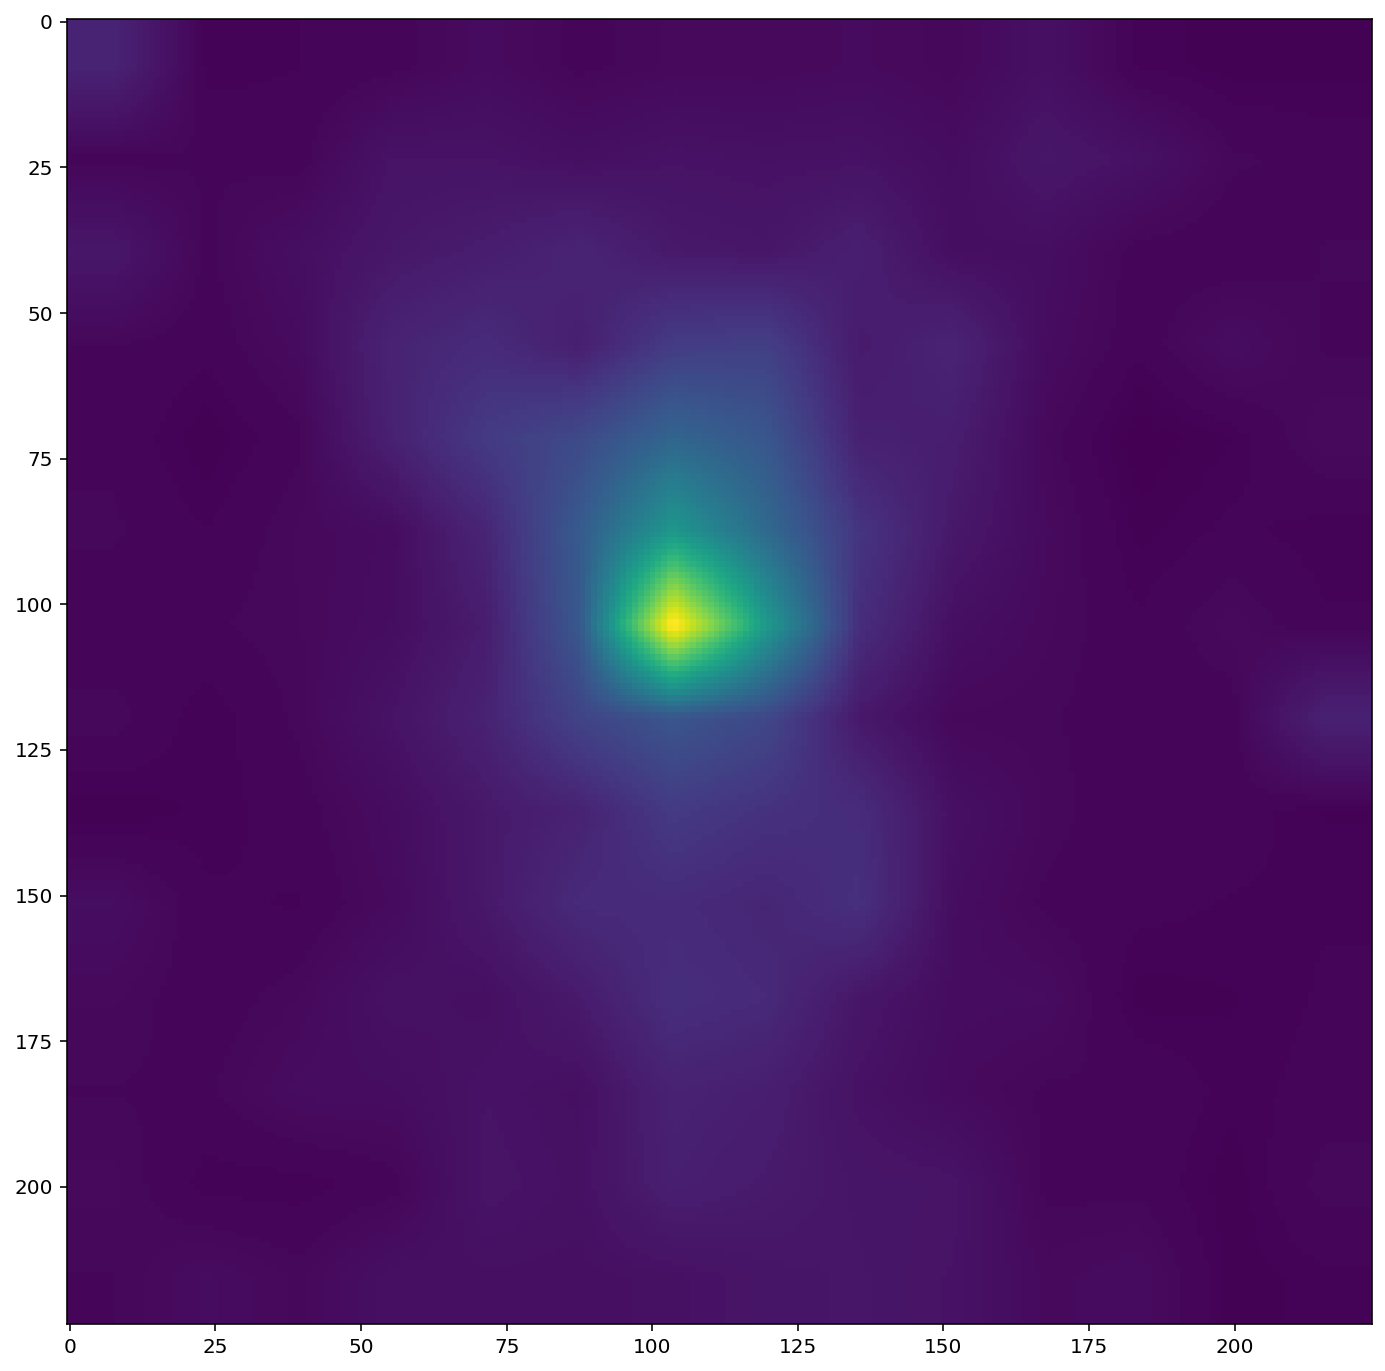

tensor([[619, 846, 818, 545, 883]])
Prediction index 0: lampshade                , score: 0.964
Prediction index 1: table lamp               , score: 0.035
Prediction index 2: spotlight                , score: 0.001
Prediction index 3: electric fan             , score: 0.000
Prediction index 4: vase                     , score: 0.000
torch.Size([197, 197])


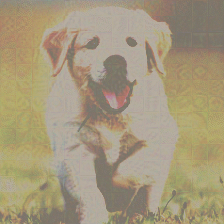

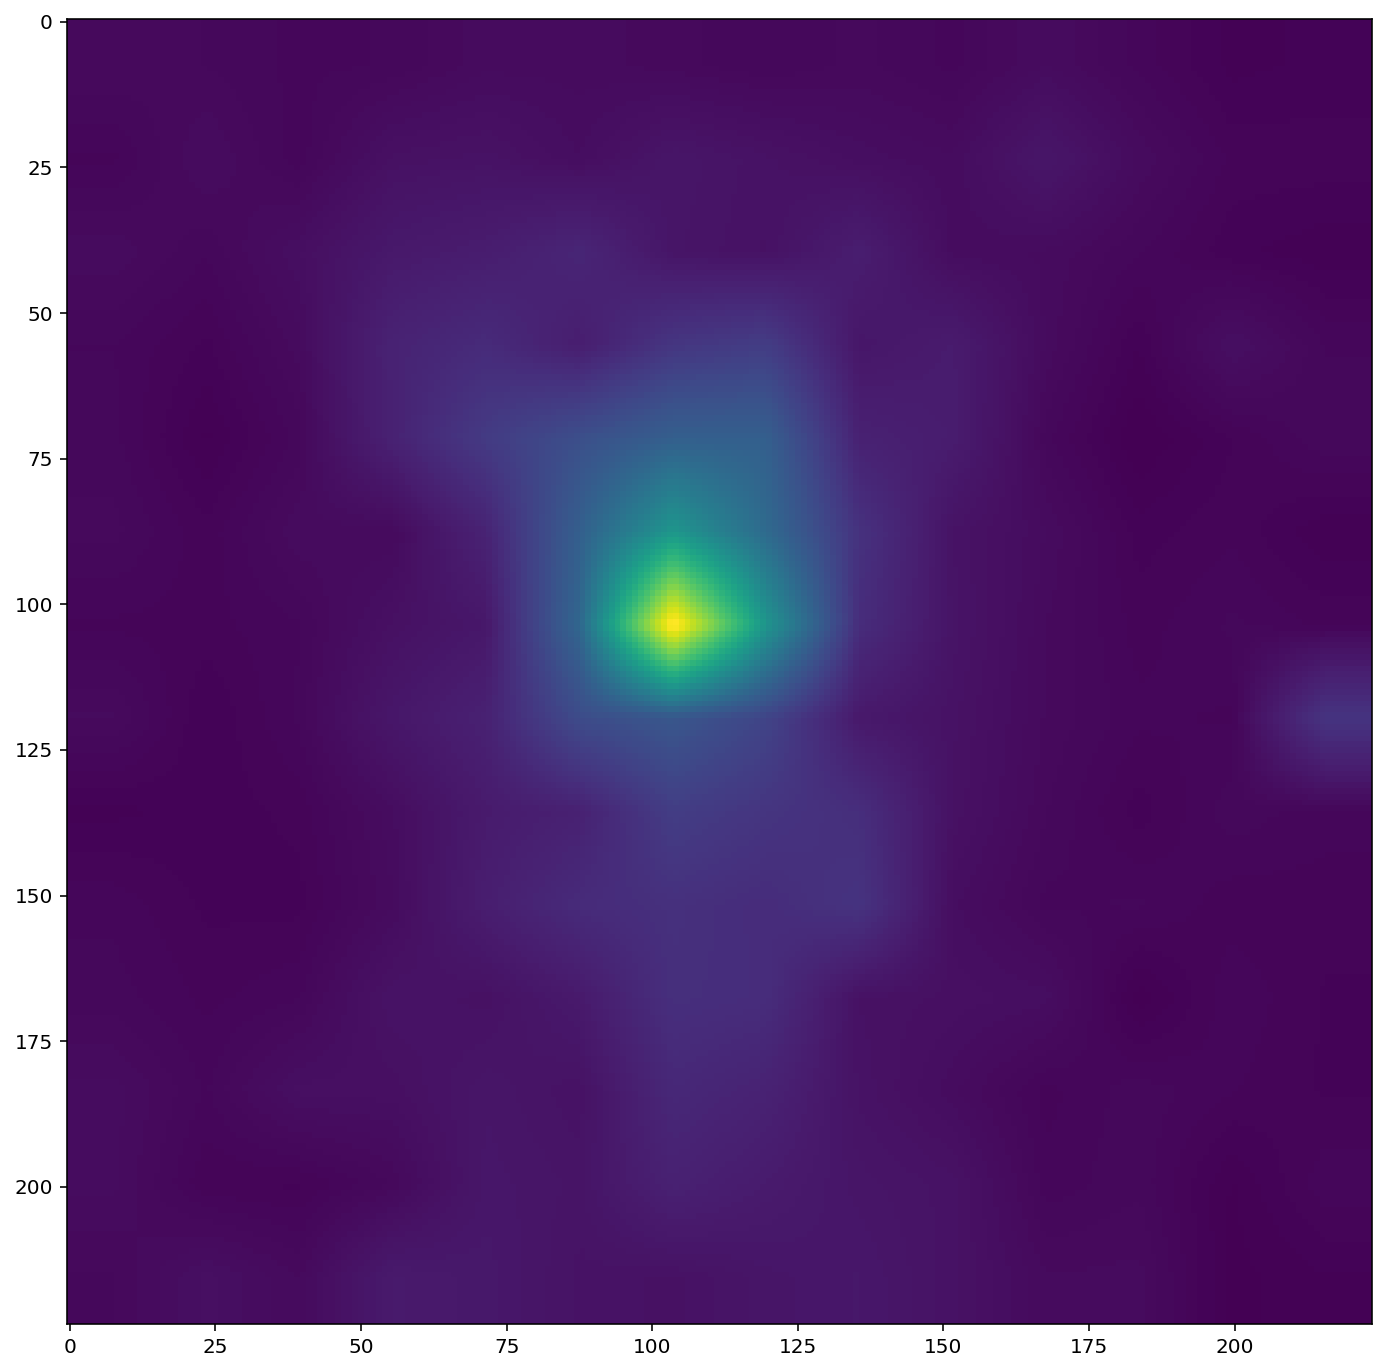

tensor([[514, 655, 542, 619, 806]])
Prediction index 0: cowboy boot              , score: 0.064
Prediction index 1: miniskirt                , score: 0.045
Prediction index 2: drumstick                , score: 0.031
Prediction index 3: lampshade                , score: 0.025
Prediction index 4: sock                     , score: 0.024
torch.Size([197, 197])


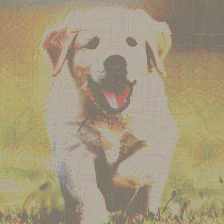

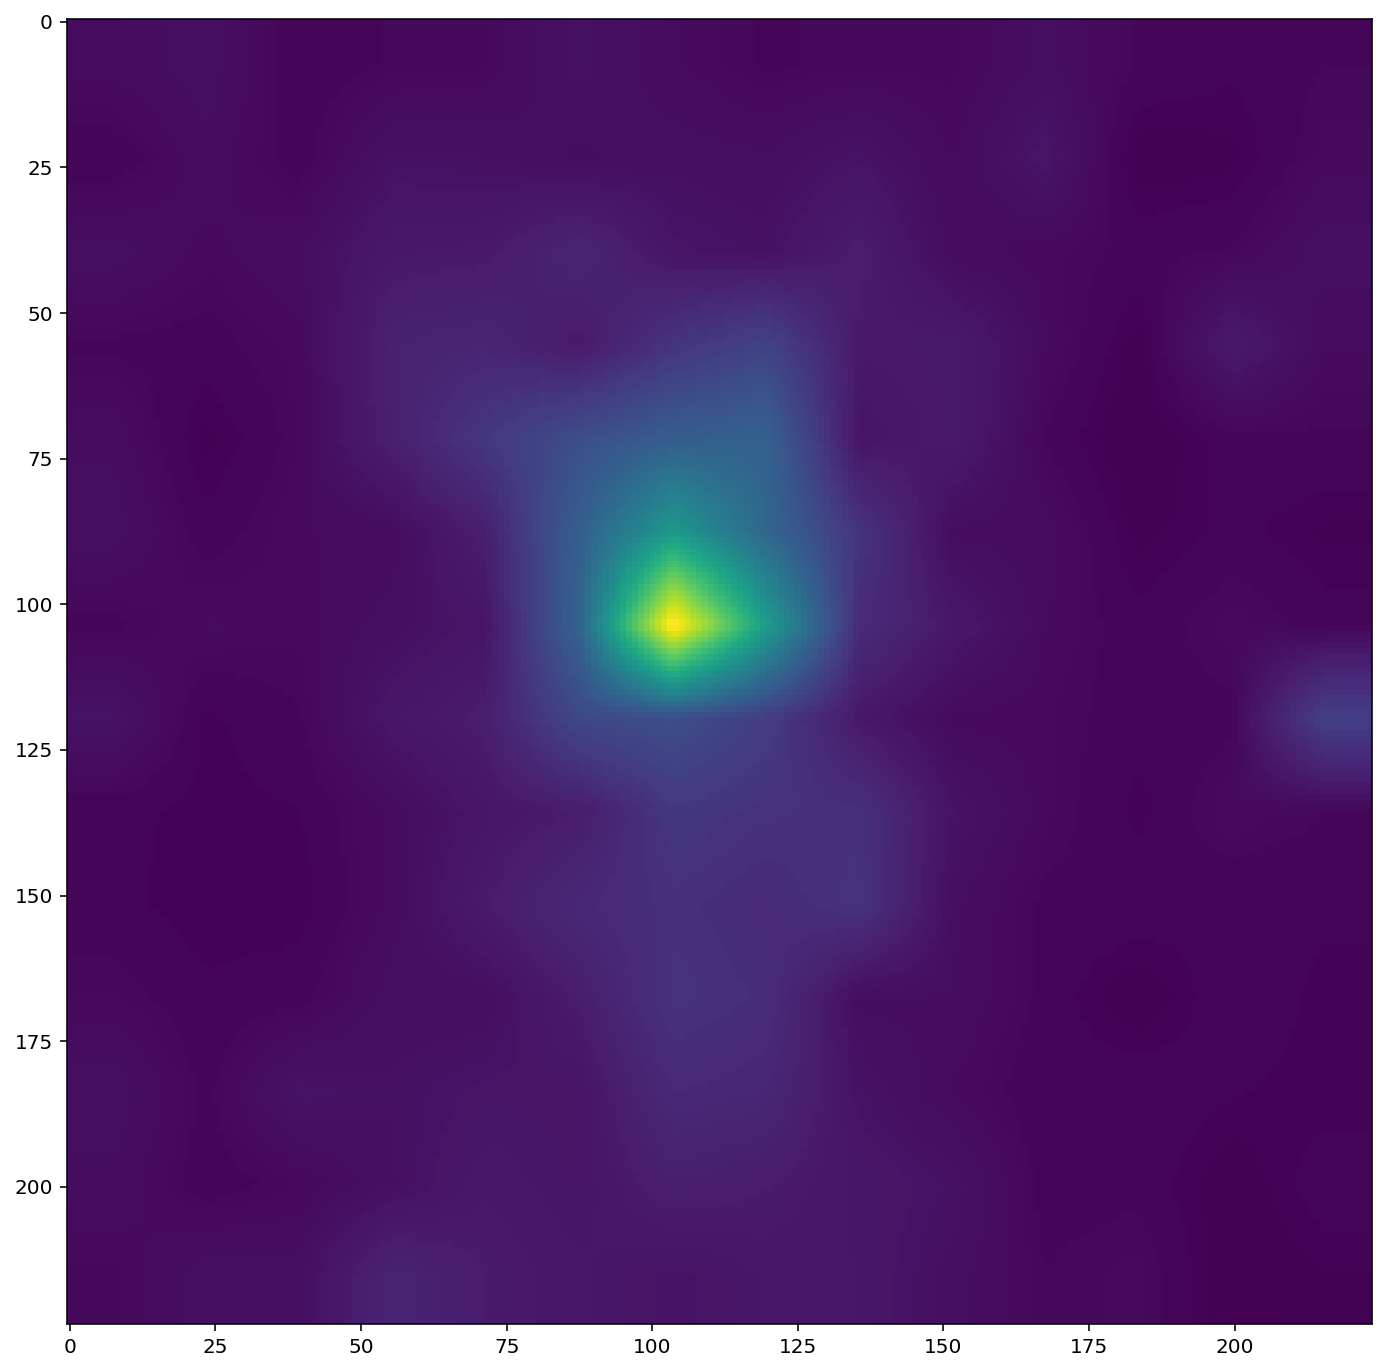

tensor([[589, 546, 889, 420, 457]])
Prediction index 0: hand blower              , score: 0.119
Prediction index 1: electric guitar          , score: 0.085
Prediction index 2: violin                   , score: 0.074
Prediction index 3: banjo                    , score: 0.065
Prediction index 4: bow tie                  , score: 0.033


([], [], [])

In [75]:
do_things(model, im, 10)

In [ ]:
""" Vision Transformer (ViT) in PyTorch

A PyTorch implement of Vision Transformers as described in
'An Image Is Worth 16 x 16 Words: Transformers for Image Recognition at Scale' - https://arxiv.org/abs/2010.11929

The official jax code is released and available at https://github.com/google-research/vision_transformer

Status/TODO:
* Models updated to be compatible with official impl. Args added to support backward compat for old PyTorch weights.
* Weights ported from official jax impl for 384x384 base and small models, 16x16 and 32x32 patches.
* Trained (supervised on ImageNet-1k) my custom 'small' patch model to 77.9, 'base' to 79.4 top-1 with this code.
* Hopefully find time and GPUs for SSL or unsupervised pretraining on OpenImages w/ ImageNet fine-tune in future.

Acknowledgments:
* The paper authors for releasing code and weights, thanks!
* I fixed my class token impl based on Phil Wang's https://github.com/lucidrains/vit-pytorch ... check it out
for some einops/einsum fun
* Simple transformer style inspired by Andrej Karpathy's https://github.com/karpathy/minGPT
* Bert reference code checks against Huggingface Transformers and Tensorflow Bert

Hacked together by / Copyright 2020 Ross Wightman
"""
import torch
import torch.nn as nn
from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from .helpers import load_pretrained
from .layers import DropPath, to_2tuple, trunc_normal_
from .resnet import resnet26d, resnet50d
from .registry import register_model


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models
    'vit_small_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/vit_small_p16_224-15ec54c9.pth',
    ),
    'vit_base_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vit_base_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_base_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    'vit_large_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_384-b3be5167.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_huge_patch16_224': _cfg(),
    'vit_huge_patch32_384': _cfg(input_size=(3, 384, 384)),
    # hybrid models
    'vit_small_resnet26d_224': _cfg(),
    'vit_small_resnet50d_s3_224': _cfg(),
    'vit_base_resnet26d_224': _cfg(),
    'vit_base_resnet50d_224': _cfg(),
}


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn1 = attn.detach().cpu()
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn1


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x1 = x
        x, attn_weight = self.attn(self.norm1(x))
        x = x1 + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, attn_weight


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        weights = []
        for blk in self.blocks:
            x, weight = blk(x)
            weights.append(weight)

        x = self.norm(x)
        return x[:, 0], weights

    def forward(self, x):
        x, weights = self.forward_features(x)
        x = self.head(x)
        return x, weights


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    if pretrained:
        # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
        kwargs.setdefault('qk_scale', 768 ** -0.5)
    model = VisionTransformer(patch_size=16, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
    model.default_cfg = default_cfgs['vit_small_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_base_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_base_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch16_224']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = default_cfgs['vit_large_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(patch_size=16, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
    model.default_cfg = default_cfgs['vit_huge_patch16_224']
    return model


@register_model
def vit_huge_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
    model.default_cfg = default_cfgs['vit_huge_patch32_384']
    return model


@register_model
def vit_small_resnet26d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet26d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_resnet26d_224']
    return model


@register_model
def vit_small_resnet50d_s3_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet50d(pretrained=pretrained_backbone, features_only=True, out_indices=[3])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_small_resnet50d_s3_224']
    return model


@register_model
def vit_base_resnet26d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet26d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_resnet26d_224']
    return model


@register_model
def vit_base_resnet50d_224(pretrained=False, **kwargs):
    pretrained_backbone = kwargs.get('pretrained_backbone', True)  # default to True for now, for testing
    backbone = resnet50d(pretrained=pretrained_backbone, features_only=True, out_indices=[4])
    model = VisionTransformer(
        img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, hybrid_backbone=backbone, **kwargs)
    model.default_cfg = default_cfgs['vit_base_resnet50d_224']
    return model
    